# Fake news prediction model


#### **NOTE**: Due to restrictions on GitHub (even with Large File Storage) we decided to upload our program set to train on a 10,000 row snippet of the full dataset. The training results from both the simple and advanced model can found in the pdf regarding this assignment. We decided to go with this approach to ensure reproduceability, but it can all be changed by switching out `"fake_news_dataset/10,000_data_cleaned_fr.csv"` with the `"995,000_rows.csv"` (of course with your own relative path as well).

# Overview
1. Dependencies
2. Importing and data exploration
3. Training the simple model
4. Using the simple model on Fake News Corpus & LIAR
5. Taining the advanced model
6. Using the advanced model on Fake news Corpus & LIAR

## Dependencies

In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Data processing

### Loading the cleaned data
We load the dataset and use tqdm to track progress. The 868346 are the number of articles left after cleaning the 995,000_rows.csv file.

In [25]:
chunk_size = 1000
rows = 868346
chunks = []

# * Load csv file with tqdm for tracking progress
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("fake_news_dataset/10,000_data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)
df = df.dropna(subset=['content', 'type'])

Loading csv file:   1%|          | 9339/868346 [00:00<00:23, 36966.65it/s]


### Distribution

In [26]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']=='fake'])}')
print(f'Reliable article amount: {len(df[df['type']=='reliable'])}')
print(f'Reliable percentage: {(len(df[df['type']=='reliable'])/len(df['type'])*100):.2f}%')

Total article amount: 8891
Fake article amount: 0
Reliable article amount: 0
Reliable percentage: 0.00%


# Simple model

We will try to add the cleaned BBC dataset to our current one, and see how the model performs.

In [27]:
df2 = pd.read_csv('bbc_dataset/bbc_cleaned_fr.csv')

# Concatenate vertically (stacking rows)
merged_df = pd.concat([df, df2], ignore_index=True)

merged_df.to_csv('bbc_dataset/merged_data.csv', index=False)

### Splitting

In [28]:
merged_df['type'] = merged_df['type'].astype(str)

X = merged_df['content']
y = merged_df['type'] 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

### Vectorization and training
We now apply a count vectorizer and SMOTE (over sampler) and fit out data with a Logistic regression model

In [29]:

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)
print(class_counts / len(y_train) * 100)

# Create feature extraction pipeline with n-grams
feature_extraction = Pipeline([
    ('vect', CountVectorizer(
        max_features=10000,             # Limit to top 10,000 features
    )),
    #('tfidf', TfidfTransformer()),
])

# Apply feature extraction to training data
X_train_features = feature_extraction.fit_transform(X_train)
print(f"\nFeature matrix shape: {X_train_features.shape}")

# Find the minimum number of samples in any class
min_class_count = min(class_counts)
print(f"Minimum class count: {min_class_count}")


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

# Show class distribution after resampling
print("\nClass distribution after resampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train_resampled)*100:.2f}%)")

# Train the logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)


Class distribution in training set:
type
1.0    5270
0.0    2971
Name: count, dtype: int64
type
1.0    63.94855
0.0    36.05145
Name: count, dtype: float64

Feature matrix shape: (8241, 10000)
Minimum class count: 2971

Class distribution after resampling:
Class 0.0: 5270 samples (50.00%)
Class 1.0: 5270 samples (50.00%)


LogisticRegression(max_iter=1000)

### Evaluation

#### Testing the model on the validation set
To see our results we use a confusion matrix as well as a classification report where we primarily look at the given `macro avg`score at the `f1-score` column.

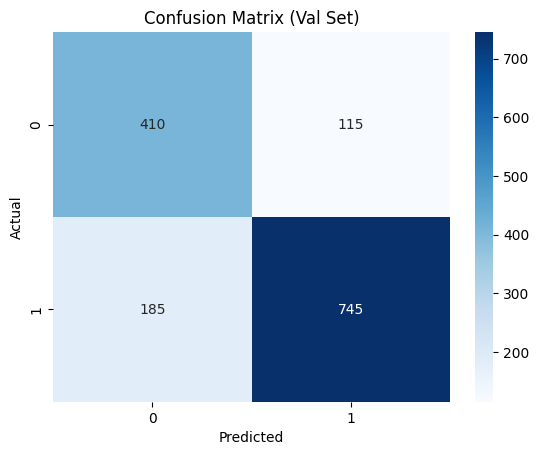


Classification Report for Val Set:
               precision    recall  f1-score   support

         0.0       0.69      0.78      0.73       525
         1.0       0.87      0.80      0.83       930

    accuracy                           0.79      1455
   macro avg       0.78      0.79      0.78      1455
weighted avg       0.80      0.79      0.80      1455



In [30]:
X_val_features = feature_extraction.transform(X_val)
y_pred = clf.predict(X_val_features)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Val Set)')
plt.show()

print("\nClassification Report for Val Set:\n", classification_report(y_val, y_pred))

## Applying the model to the liars dataset


Validation Set Accuracy: 0.5472557223726311

Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.56      0.91      0.69      4488
           1       0.47      0.10      0.17      3638

    accuracy                           0.55      8126
   macro avg       0.51      0.51      0.43      8126
weighted avg       0.52      0.55      0.46      8126



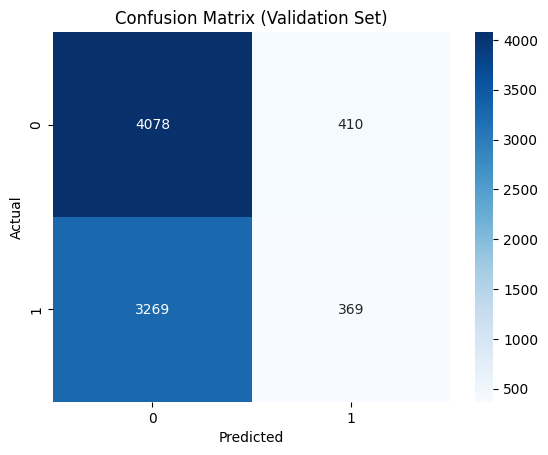

In [31]:
# Load dataset
liar_data = pd.read_csv("liar_dataset/liar_fr.csv")

# Define features and target
X_liar_val = liar_data['content']
y_liar_val = liar_data['type'].astype(int)

# Transform validation data using a pre-fitted vectorizer
liar_features = feature_extraction.transform(X_liar_val)  # No fit, just transform

# Predict using a pre-trained classifier
y_liar_val_pred = clf.predict(liar_features)

y_liar_val_pred = y_liar_val_pred.astype(float).astype(int)

# Evaluation metrics
print("\nValidation Set Accuracy:", accuracy_score(y_liar_val, y_liar_val_pred))
print("\nClassification Report for Validation Set:\n", classification_report(y_liar_val, y_liar_val_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_liar_val, y_liar_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

### Retraining the model with metadata 'domain_names' 

Available columns: ['Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'meta_description', 'tags', 'summary', 'source', 'processed_category']
Features being used for training:
- text: content

Feature matrix shape after preprocessing: (7557, 10000)

Class distribution in training set:
type
1.0    4586
0.0    2971
Name: count, dtype: int64

Applying SMOTE...

Training model...

Test set evaluation:
Accuracy: 0.8193

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       525
         1.0       0.88      0.82      0.85       809

    accuracy                           0.82      1334
   macro avg       0.81      0.82      0.81      1334
weighted avg       0.82      0.82      0.82      1334


Feature importance analysis:

Top 20 most important words:
1. sourc: -5.5981
2. blockchain: -5.1349
3. getti: -5.0006
4. cent: -4.411

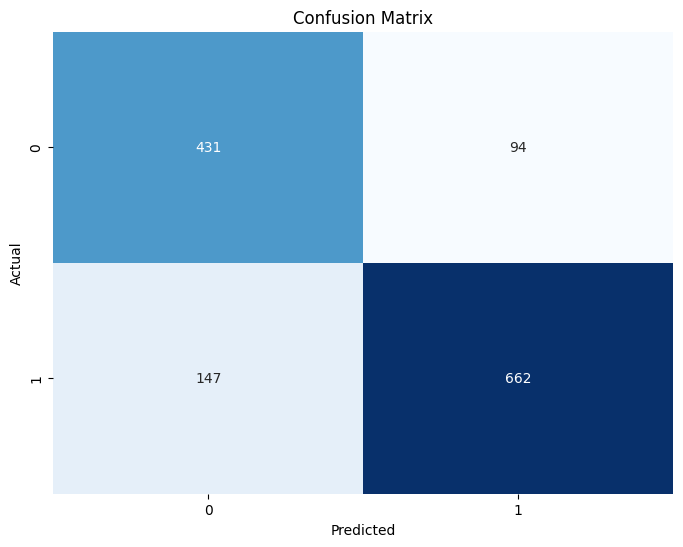

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

text_column = 'content'
target_column = 'type'

X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns=[target_column]), 
    df[target_column], 
    test_size=0.15, 
    random_state=42, 
    stratify=df[target_column]
)

# Additional features to include (add your own column names)
categorical_columns = ['domain_names']  # Add your categorical columns

# Check if columns exist
all_columns = [text_column] + categorical_columns + [target_column]
missing_columns = [col for col in all_columns if col not in df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
    print("Available columns:", df.columns.tolist())
    # Filter to only use columns that exist
    categorical_columns = [col for col in categorical_columns if col in df.columns]

# Create the feature processing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Text feature processing
        ('text', Pipeline([
            ('vect', CountVectorizer(lowercase=True, max_features=10000)),
            ('tfidf', TfidfTransformer())
        ]), text_column),
        
        # Categorical feature processing
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns) if categorical_columns else None
    ],
    remainder='drop'  # Drop any other columns
)

# Remove any None transformers
preprocessor.transformers = [t for t in preprocessor.transformers if t is not None]

# Split data
X = df.drop(columns=[target_column])
y = df[target_column]

# Print feature information
print("Features being used for training:")
for name, _, columns in preprocessor.transformers:
    if isinstance(columns, list):
        print(f"- {name}: {columns}")
    else:
        print(f"- {name}: {columns}")

# Apply preprocessing
preprocessor.fit(X_train)

# Transform all three sets
X_train_features = preprocessor.transform(X_train)
X_val_features = preprocessor.transform(X_val)

print(f"\nFeature matrix shape after preprocessing: {X_train_features.shape}")

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)

# Find minimum class count for SMOTE
min_class_count = min(class_counts)

# Apply SMOTE if possible
if min_class_count >= 6:
    print("\nApplying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
elif min_class_count > 1:
    print(f"\nMinority class has only {min_class_count} samples. Using SMOTE with fewer neighbors...")
    k_neighbors = min(min_class_count - 1, 5)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
else:
    print("\nToo few samples for SMOTE. Using original data with class weights.")
    X_train_resampled, y_train_resampled = X_train_features, y_train

# Train model
print("\nTraining model...")
if min_class_count <= 1:
    # Use class weights if SMOTE can't be applied
    clf = LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced')
else:
    clf = LogisticRegression(max_iter=1000, C=1.0)

clf.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
X_val_features = preprocessor.transform(X_val)
y_pred = clf.predict(X_val_features)

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nFeature importance analysis:")

# Try to get feature names for text features
try:
    text_transformer = preprocessor.named_transformers_['text']
    text_features = text_transformer.named_steps['vect'].get_feature_names_out()
    
    # Get coefficients for binary classification
    if len(clf.classes_) == 2:
        coefficients = clf.coef_[0]
    else:
        # For multiclass, we'll just look at the first class for simplicity
        coefficients = clf.coef_[0]
    
    # Only show importance for text features
    n_text_features = len(text_features)
    text_importance = list(zip(text_features, coefficients[:n_text_features]))
    
    # Sort by absolute importance
    text_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nTop 20 most important words:")
    for i, (feature, importance) in enumerate(text_importance[:20], 1):
        print(f"{i}. {feature}: {importance:.4f}")

except (KeyError, AttributeError) as e:
    print(f"Could not analyze text feature importance: {e}")

# Evaluate on validation set first
y_val_pred = clf.predict(X_val_features)
print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Advanced model
We now try to train on the original dataset again (not LIAR), but instead utilize an advanced model.

### Splitting

In [33]:
X = df['content']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

### Vectorization
A TF-IDF Vectorizer is applied and fitted to our data.

In [34]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
1.0    4316
0.0    2796
Name: count, dtype: int64
Test class distribution:
type
1.0    1079
0.0     700
Name: count, dtype: int64


### Over sampling
We notice from previous cell that we had an uneven distribution of 1.0 & 0.0, and so we use a ROS (random over sampler).
We use `ROS` instead of `SMOTE` due to `ROS` performing as good as `SMOTE`, but having a much, much longer execution time.

In [35]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
1.0    4316
0.0    4316
Name: count, dtype: int64


## Training and evaluation

### Model training
For training the model an MLP Classifer is used, with the specific running model `adam`.
We originally trined the model on the large dataset, where we found using 3 layers with 50, 50 & 50 neurons resulted in some of the best results with minimal execution time.
We also tried adding another layer, but that increased the execution time 10-fold and yielded the same, if not worse, results.
We reached a macro avg of 85% with those neurons, but when training on a snippet of 10,000 articles, the performance dropped - which is to be expected. The output for 10,000 articles can be seen a bit further down, but both the confusion matrix and the classification report for the full 995,000 articles can be found in the pdf.

In [36]:
classifier = MLPClassifier(
    solver='adam',
    alpha=1e-4,
    hidden_layer_sizes=(50, 50, 50),
    shuffle=False,
    random_state=42,
    tol=0.0001,
    verbose=True,
    max_iter=50,
    batch_size=1024,
    learning_rate='adaptive',
    n_iter_no_change=4
)
classifier.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.70070015
Iteration 2, loss = 0.68052507
Iteration 3, loss = 0.66165329
Iteration 4, loss = 0.62881541
Iteration 5, loss = 0.57572215
Iteration 6, loss = 0.50745692
Iteration 7, loss = 0.42351423
Iteration 8, loss = 0.33564568
Iteration 9, loss = 0.25552599
Iteration 10, loss = 0.19186868
Iteration 11, loss = 0.14315988
Iteration 12, loss = 0.10572785
Iteration 13, loss = 0.07733479
Iteration 14, loss = 0.05585387
Iteration 15, loss = 0.04039338
Iteration 16, loss = 0.02938960
Iteration 17, loss = 0.02178989
Iteration 18, loss = 0.01651039
Iteration 19, loss = 0.01290621
Iteration 20, loss = 0.01033163
Iteration 21, loss = 0.00840977
Iteration 22, loss = 0.00680910
Iteration 23, loss = 0.00562477
Iteration 24, loss = 0.00479750
Iteration 25, loss = 0.00413636
Iteration 26, loss = 0.00360761
Iteration 27, loss = 0.00320093
Iteration 28, loss = 0.00287812
Iteration 29, loss = 0.00262190
Iteration 30, loss = 0.00240742
Iteration 31, loss = 0.00223662
Iteration 32, los

MLPClassifier(batch_size=1024, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=50, n_iter_no_change=4,
              random_state=42, shuffle=False, verbose=True)

### Evaluation

#### Note: the classifier here is trained on a small 10,000 row snippet of the full dataset which yields lower results for the macro avg.

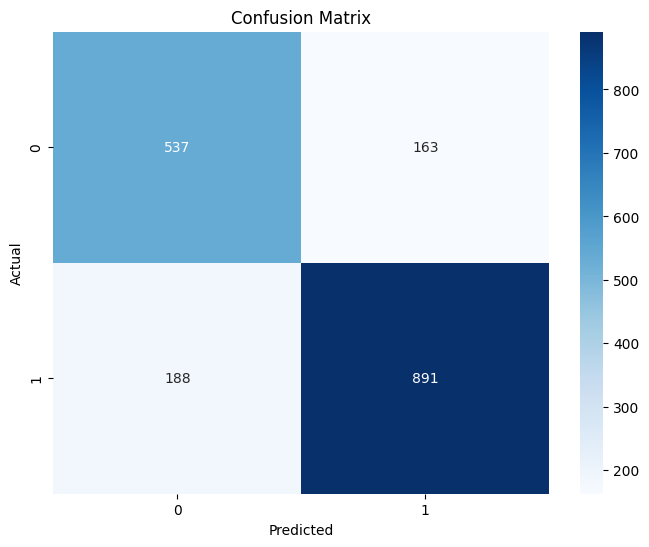

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       700
         1.0       0.85      0.83      0.84      1079

    accuracy                           0.80      1779
   macro avg       0.79      0.80      0.79      1779
weighted avg       0.80      0.80      0.80      1779



In [37]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

## Advanced with LIAR
Lastly we used the model but on the LIAR dataset.


Validation Set Accuracy: 0.4837558454344081

Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.55      0.37      0.44      4488
           1       0.45      0.62      0.52      3638

    accuracy                           0.48      8126
   macro avg       0.50      0.50      0.48      8126
weighted avg       0.50      0.48      0.48      8126



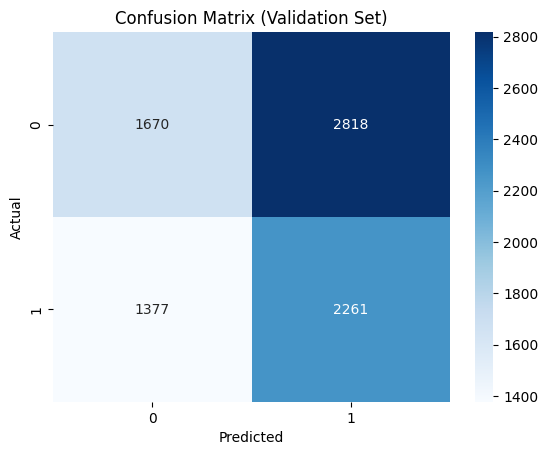

In [38]:
# Load dataset
liar_data = pd.read_csv("liar_dataset/liar_fr.csv")

# Define features and target
X_liar_val = liar_data['content']  # Text content
y_liar_val = liar_data[target_column]  

# Transform validation data using a pre-fitted vectorizer
liar_features = feature_extraction.transform(X_liar_val)  # No fit, just transform

# Predict using a pre-trained classifier


y_liar_val_pred = clf.predict(liar_features)

# Evaluation metrics
print("\nValidation Set Accuracy:", accuracy_score(y_liar_val, y_liar_val_pred))
print("\nClassification Report for Validation Set:\n", classification_report(y_liar_val, y_liar_val_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_liar_val, y_liar_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()